* Name: `dissipation-theory--Study-10.ipynb`
* Author: John A. Marohn
* Date: 2023-10-09 (reconstructed 2023-10-31)
* Continued from: `dissipation-theory--Study-9.ipynb`
* Continued to: --
* Summary: Plot the friction $\gamma_{\perp}$ versus height $h$ expected for a thin organic semiconductor sample backed by a metal.

# Preliminaries

In [1]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

In [3]:
THIS = 'dissipation-theory--Study-10'

# Study A

Consider a semiconductor sample with
* thickness $h_{\mathrm{s}} = 110 \: \mathrm{nm}$
* complex relative dielectric constant $\epsilon_{\mathrm{s}} = 3.4 - 0. j$
* charge mobility $\mu = 10^{-4} \: \mathrm{cm}^2 \: \mathrm{V}^{-1} \mathrm{s}^{-1}$
  
and a cantilever with
* resonance frequency $f_{\mathrm{c}} = 63 \: \mathrm{kHz}$
* tip voltage $V_{\mathrm{ts}} = 2 \: \mathrm{V}$
* radius $r = 30 \: \mathrm{nm}$
* tip-sample separation $h = 110 \: \mathrm{nm}$

The semiconductor is backed by a metal, which we will model as a dielectric with relative dielectric constant $\epsilon_{\mathrm{d}} = 10^{6}$.   

Use Lekkala and Loring's `Model 1` to compute the perpendicular friction $\gamma_{\perp}$ versus charge density $\rho$.  Plot $\gamma_{\perp}$ *vs.* $\rho$ and then versus conductivity $\sigma = e \mu \rho$.

In [19]:
hs = ureg.Quantity(110, 'nanometer')   # measured
mu = ureg.Quantity(1e-4, 'cm^2/(s V)') # avg of lit values
epsilons = complex(3.4, 0.)            # wild guess

fc = ureg.Quantity(63, 'kHz')       # measured
Vts = ureg.Quantity(2, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
d = ureg.Quantity(120, 'nanometer') # measured

In [20]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        d.to('m').magnitude), 
    epsilon_s=epsilons,
    h_s=hs.to('m').magnitude,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=1e21,
    epsilon_d=complex(1.0e6, 0.),
    z_r=d.to('m').magnitude)

Create an array of charge density $\rho$ to loop over.  Create a corresponding array of conductivity $\sigma = e \mu \rho$.

In [21]:
rho = ureg.Quantity(np.logspace(start=17, stop=27, num=50), '1/m^3')

In [22]:
sigma = (qe * mu * rho).to('1/(ohm m)')

Loop over the conductivities and compute the perpendicular friction.

In [23]:
result1 = {
    'rho': rho,
    'sigma': sigma,
    'gamma': ureg.Quantity(np.zeros_like(rho), 'pN s/m')
}

for index, rho_ in enumerate(rho):

        sample1_jit.rho = rho_.to('1/m^3').magnitude
        result1['gamma'][index] = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')

Plot the friction versus charge density.

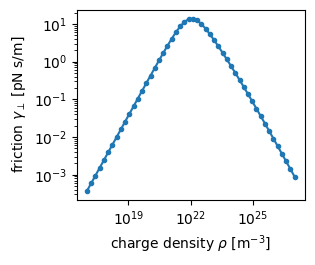

In [24]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.-')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1a.png', dpi=300)
plt.savefig(THIS + '--Fig-1a.pdf')

plt.show()

Now plot the friction versus conductivity instead.

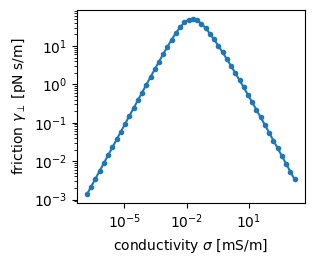

In [10]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['sigma'].to('(millisiemens/m)').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.-')
plt.xlabel('conductivity $\sigma$ [mS/m]')
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1b.png', dpi=300)
plt.savefig(THIS + '--Fig-1b.pdf')

plt.show()

# Study B

Try to capture the Study A friction using the Dwyer model.

In [11]:
from dissipationtheory.capacitance import CsphereOverSemi
from dissipationtheory.constants import epsilon0

## Close-up limit

Assumes tip image charge is at the leading edge of the sphere.

In [26]:
d_array = ureg.Quantity(np.array([d.to('m').magnitude]), 'm')
c0 = CsphereOverSemi(0, d_array, r, epsilons.real, nterm=20)
c1 = CsphereOverSemi(1, d_array, r, epsilons.real, nterm=20)

In [27]:
Rs = (hs /(sigma * np.pi * d**2)).to('ohm')
Cs = ((epsilon0 * 3.4 * np.pi * d**2)/hs).to('F')
omega = (2 * np.pi * fc).to('1/s')

In [28]:
c0.to('F')

Magnitude,[3.530636565678586e-18]
Units,farad


In [29]:
Cs.to('F')

1.2380760616983578e-17 <Unit('farad')>

In [30]:
gamma2 = (c1**2 * Vts**2 * Rs)/(1 + (omega * Rs * (c0 + Cs))**2)

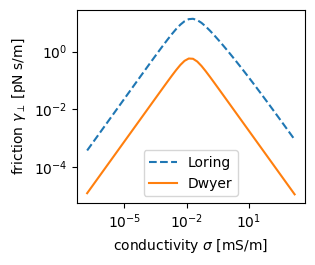

In [31]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['sigma'].to('(millisiemens/m)').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '--', label='Loring')

plt.loglog(
    sigma.to('(millisiemens/m)').magnitude,
    gamma2.to('pN s/m').magnitude,
    '-', label='Dwyer')

plt.xlabel('conductivity $\sigma$ [mS/m]')
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend()
plt.tight_layout()

plt.savefig(THIS + '--Fig-2a.png', dpi=300)
plt.savefig(THIS + '--Fig-2a.pdf')

plt.show()

## Far-away limit

Take $d \rightarrow d + r$, assumes the tip image charge is at the center of the sphere.  The friction here will be smaller, because the effective tip charge is further away from the sample.

In [33]:
d_array = ureg.Quantity(np.array([(d + r).to('m').magnitude]), 'm')
c0 = CsphereOverSemi(0, d_array, r, epsilons.real, nterm=20)
c1 = CsphereOverSemi(1, d_array, r, epsilons.real, nterm=20)

In [36]:
Rs = (hs /(sigma * np.pi * (d+r)**2)).to('ohm')
Cs = ((epsilon0 * 3.4 * np.pi * (d+r)**2)/hs).to('F')
omega = (2 * np.pi * fc).to('1/s')
gamma2 = (c1**2 * Vts**2 * Rs)/(1 + (omega * Rs * (c0 + Cs))**2)

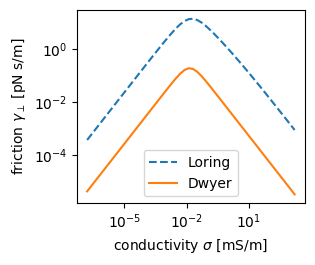

In [37]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['sigma'].to('(millisiemens/m)').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '--', label='Loring')

plt.loglog(
    sigma.to('(millisiemens/m)').magnitude,
    gamma2.to('pN s/m').magnitude,
    '-', label='Dwyer')

plt.xlabel('conductivity $\sigma$ [mS/m]')
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend()
plt.tight_layout()

plt.savefig(THIS + '--Fig-2b.png', dpi=300)
plt.savefig(THIS + '--Fig-2b.pdf')

plt.show()

# Play with different scalings

Play with different scalings for resistance and capacitance in Dwyer.  Use the far-away limit.

In [38]:
d_array = ureg.Quantity(np.array([(d + r).to('m').magnitude]), 'm')
c0 = CsphereOverSemi(0, d_array, r, epsilons.real, nterm=20)
c1 = CsphereOverSemi(1, d_array, r, epsilons.real, nterm=20)

Play with difference scalings.

In [ ]:
Rs = (hs /(sigma * np.pi * (d+r)**2)).to('ohm')
Cs = ((epsilon0 * 3.4 * np.pi * (d+r)**2)/hs).to('F')
omega = (2 * np.pi * fc).to('1/s')
gamma2 = (c1**2 * Vts**2 * Rs)/(1 + (omega * Rs * (c0 + Cs))**2)

Replot.

In [ ]:
fig = plt.figure(figsize=(3.25, 2.75))

plt.loglog(
    result1['sigma'].to('(millisiemens/m)').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '--', label='Loring')

plt.loglog(
    sigma.to('(millisiemens/m)').magnitude,
    gamma2.to('pN s/m').magnitude,
    '-', label='Dwyer')

plt.xlabel('conductivity $\sigma$ [mS/m]')
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.legend()
plt.tight_layout()

plt.savefig(THIS + '--Fig-2c.png', dpi=300)
plt.savefig(THIS + '--Fig-2c.pdf')

plt.show()